
# UofT DSI-CARTE ML Bootcamp
#### Date
#### Fairness and Equity - Lab 1, Day 4
#### Teaching team: Eldan Cohen, Alex Olson, Nakul Upadhya, Shehnaz Islam
##### Lab author: Nakul Upadhya

As decision-making increasingly relies on artificial intelligence, the issue of fairness and equity in machine learning is rapidly becoming a larger concern. In this lab, we will introduce various metrics that help analyze the biases of our models, as well as techniques that can help mitigate these discrepancies.

The main packages we will be using in this lab is `fairlearn` [1] and `shap` [4] along with all the other packages we have previously used.



In [ ]:
## Install Packages
!pip install fairlearn
!pip install shap
!pip install xgboost

## Import packages
import numpy as np
import pandas as pd

# IGNORE THESE LINES. They just turn off some annoying messages associated with Fairlearn
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 8.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 18.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Setup
For this lab, we will be using the Diabetes 130-Hospitals Dataset [2]. This dataset consists of 10 years worth of clinical care data at 130 US hospitals and integrated delivery networks. Each record represents the admission record for a patient diagnosed with diabetes whose stay lasted between one to fourteen days. The features describing each encounter include demographics, diagnoses, diabetic medications, number of visits in the year preceding the encounter, and payer information, as well as whether the patient was readmitted after release, and whether the readmission occurred within 30 days of the release [2].

One common task on this dataset is predicting whether or not a patient will be re-admitted to the hospital.


Lets first read all the data in. We will also subset the data and only work with a few columns.

In [ ]:
from fairlearn.datasets import fetch_diabetes_hospital

diabetes_information = fetch_diabetes_hospital() # Get dataset
df = diabetes_information['data'] # Access the data
df = df.dropna() # Remove null data points
response = df['readmit_binary'] # Save the target variable
df = df.drop(columns = ['readmitted', 'readmit_binary']) # Remove the target columns
# We remove both `readmitted` and `readmit_binary` since they are effectively the same data

df.info() # Print the DF Info

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   race                      101766 non-null  object  
 1   gender                    101766 non-null  object  
 2   age                       101766 non-null  object  
 3   discharge_disposition_id  101766 non-null  object  
 4   admission_source_id       101766 non-null  object  
 5   time_in_hospital          101766 non-null  int64   
 6   medical_specialty         101766 non-null  object  
 7   num_lab_procedures        101766 non-null  int64   
 8   num_procedures            101766 non-null  int64   
 9   num_medications           101766 non-null  int64   
 10  primary_diagnosis         101766 non-null  object  
 11  number_diagnoses          101766 non-null  int64   
 12  max_glu_serum             101766 non-null  object  
 13  A1Cresult                 101

Now lets pre-process the data a bit. We will:
* Scale any numerical columns to be between 0 and 1.
* Convert variables with only two values into 0 and 1
* Use one-hot-encoding on the non-binary categorical variables.

In [ ]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

df_list = []

# Select numeric data and scale it

numeric_columns = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications', 'number_diagnoses']
numeric_data = df[numeric_columns] # select relevant columns
scaler = MinMaxScaler() # Create our scaler
numeric_data[numeric_columns] = scaler.fit_transform(numeric_data[numeric_columns]) # Fit our scaler
df_list.append(numeric_data) # Add the transformed data to a list

# Select binary true/false columns and turn them into zeros and ones
true_false_columns = ['medicare', 'medicaid', 'had_emergency', 'had_inpatient_days','had_outpatient_days']
true_false_data = df[true_false_columns]
true_false_data.replace({'False': 0, 'True': 1}, inplace=True) # replace with numbers
true_false_data = true_false_data.astype(int) # Convert from categorical to numeric
df_list.append(true_false_data)

# One hot encoding of the categorical columns
categorical_columns = ['race','gender','age','max_glu_serum','A1Cresult',
                       'insulin','change','diabetesMed']
categorical_data = df[categorical_columns]
encoder = OneHotEncoder(sparse_output=False) # Create our One-Hot Encoder
encoded_data = encoder.fit_transform(categorical_data) # Transforme the data

# Rename the resultant columns so the names make sense
end_features = []
for feature, categories in zip(categorical_columns, encoder.categories_):
  end_features = end_features + [f"{feature}_{category}" for category in categories]

encoded_data = pd.DataFrame(encoded_data, columns = end_features)
df_list.append(encoded_data)

# Join all the data back together
X = pd.concat(df_list, axis=1)

Lets also split this into a train and test set.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, response, test_size=0.3, random_state=42)
print(f"There are {len(y_train)} training points and {len(y_test)} testing_points")

There are 71236 training points and 30530 testing_points


## Explainability

One way we can use machine learning is to explore potential systemic issues present in the data. For this task, we can use interpretable models such as linear/logistic regression and decision trees.

Lets try fitting a 3 layer decision tree on our model and print out the testing accuracy and what features are used.



In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score
import graphviz # Package containing visualization tools

tree_clf = DecisionTreeClassifier(max_depth = 3)

tree_clf.fit(X_train, y_train)

accuracy = accuracy_score(y_test, tree_clf.predict(X_test)) * 100
print(f"Test Accuracy: {accuracy :.2f}%")

Test Accuracy: 61.69%


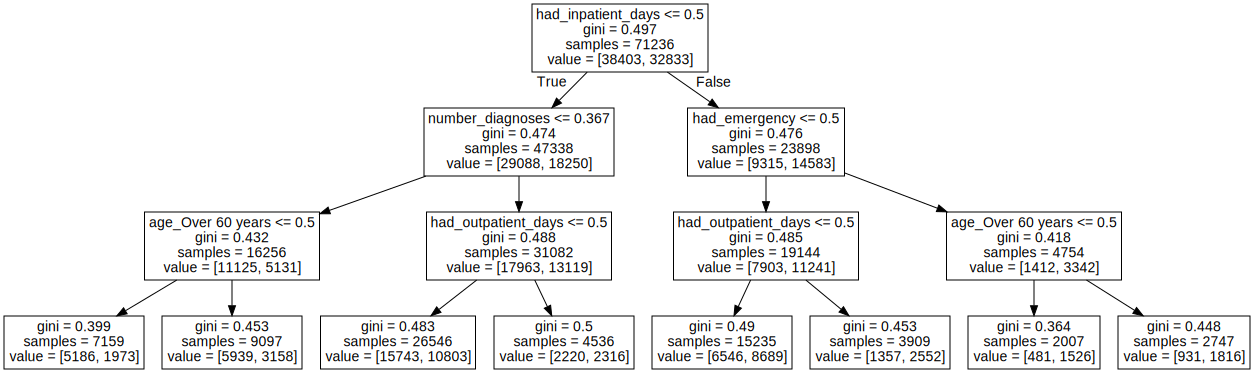

In [ ]:
export_graphviz(tree_clf, out_file="mytree.dot", feature_names=X_train.columns) # Save the visualization of the tree
with open("mytree.dot") as f: # read the file back in
    dot_graph = f.read()
graphviz.Source(dot_graph) # display the tree


Another common way to understand a model's decision is through looking at feature importance. By examining what features are being heavily used and how they impact the end predictions, we can understand patterns in the underlying system that may not have been apparent.

**Your Turn**
1. In the cell below, we plot out the feature importance for our decision tree. Do the results align with the splits you noticed in the above tree? *Yes. The most important feature is had_inpatient_days and we can see from the tree above that it is the split at the root node and creates the most seperation*


In [ ]:
import plotly.express as px # Interactive Plotting Package

tree_importances = pd.DataFrame()
tree_importances['feature'] = X_train.columns
tree_importances['tree_importance'] = tree_clf.feature_importances_
tree_importances.sort_values(by = 'tree_importance', inplace =True, ascending = False)
# Remove features without any importance
importances = tree_importances[tree_importances['tree_importance'] > 0]
px.bar(importances, x = 'feature', y = 'tree_importance')

Unfortunately the decision tree is not the ideal model for many tasks, and we may want some increased complexity and may switch to models such as XGBoost or SVM. However, we still may want to understand some of the decision mechanisms present.

Since XGBoost uses hundreds or thousands or trees in its prediction, it is not reasonable to plot those trees out and examine each one of them. Luckily, XGBoost still provides feature importance. Lets train an XGBoost network and see how this works:


In [ ]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)
accuracy = accuracy_score(y_test, xgb_clf.predict(X_test)) * 100
print(f"Test Accuracy: {accuracy :.2f}%")
importances = pd.DataFrame()
importances['feature'] = X_train.columns
importances['importance'] = xgb_clf.feature_importances_
importances.sort_values(by = 'importance', inplace =True, ascending = False)
# Remove features without any importance
importances = importances[importances['importance'] > 0]
px.bar(importances, x = 'feature', y = 'importance')

Test Accuracy: 62.17%


Notice how the XGBoost model used many more features than the decision tree model. However, the features that were important in the decision tree are also some of the more important features in the XGBoost model.

Not all models can provide feature importance however. One example of this is SVM where it simply creates hyperplanes to seperate classes. So what do we do in this case? This is where *post-hoc interpretability* methods come into play. Post-hoc methods work y taking in a trained models, modifying the inputs, and examining how significantly the outputs changed.

One such interpretability tool is SHAP (Shapely Additive Values). SHAP provides feature importance by using methods from game theory to estimate the contribution of each feature towards the final prediction.


SHAP can provide a sense of both local (explaining a single prediction) and global (explaining general prediction trends) interpretability.

To start, we first need to train a model to explain. For this exercise, we will use SVM with a radial kernel

In [ ]:
from sklearn.svm import SVC

svc_clf = SVC(kernel = 'rbf', max_iter = 2000)
svc_clf.fit(X_train, y_train)
accuracy = accuracy_score(y_test, svc_clf.predict(X_test)) * 100
print(f"Test Accuracy: {accuracy :.2f}%")

Test Accuracy: 53.28%


Now to start our explanation process. We start off by first creating a summary of our dataset (this is to make SHAP run faster) and creating our explainer object.





In [ ]:
import shap
# rather than use the whole training set to estimate expected values, we summarize with
# a set of weighted kmeans, each weighted by the number of points they represent.
# this helps everything run faster
X_train_summary = shap.kmeans(X_train, 7)

# Create the shap explainer by passing in our model's predict function and
# the summarized training set
ex = shap.KernelExplainer(svc_clf.predict, X_train_summary, feature_names = X_train.columns)

# We are also only going to look at 100 points (to make it easier to visualize)
X_test_subset = X_test.sample(100, random_state = 42).reset_index(drop=True)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


#### Local Explainability

Let's first look into the local explainability provided by SHAP by examining what contributes to the predictions of the first datapoint in our testing subset.

In [ ]:
shap.initjs()
first_datapoint = X_test_subset.iloc[1]
single_point_shap_values = ex.shap_values(first_datapoint)
shap.force_plot(ex.expected_value, single_point_shap_values, X_test_subset.iloc[0])

In the plot above, feature values that increased the chance of the model predicting a readmission are in red and have arrows that point to the right (they provide a positive force) and feature values that detract from the probability of readmission are in blue and point to the left. The larger the arrow, the larger the contribution.

**Your Turn**

* What features seem to have the most negative impact to the end prediction of the data point you chose? What about the one with the most positive impact? *The feature with the most negative impact is the insulin_down feature and the one with the highest positive impact is change_ch*
* Choose a different data point and see if you see any similarities in the features used and their impact towards the end prediction. *The same features are the most important*


#### Global Explanability
We can get a sense of global interpretability from SHAP by examining trends in the SHAP values across the variable values. To do this, we can generate a summary plot of the calculated values. NOTE: This may take a while.....

  0%|          | 0/100 [00:00<?, ?it/s]

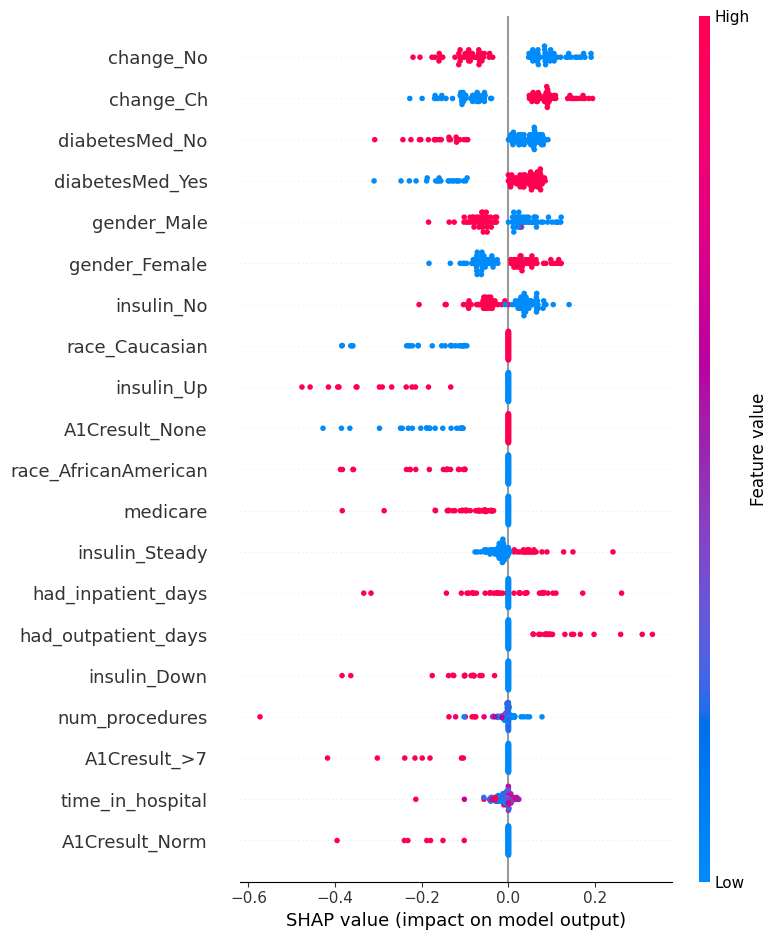

In [ ]:
shap.initjs()
shap_values = ex.shap_values(X_test_subset)
shap.summary_plot(shap_values, X_test_subset)

The color of the point reflects the value of a given feature in a given data point. For example, a red point in `diabetesMed_Yes` means that the feature took a value of 1 (true) and a blue point means a value of 0 (false). The X-axis of this plot represents SHAP contribution (the estimated impact on the end model prediction). By examining the distribution of the feature values across the x-axis, we can find what features may

In [ ]:
abs_shap_values = np.abs(shap_values)
shap_sums = np.sum(abs_shap_values, axis=0)
importances = pd.DataFrame()
importances['feature'] = X_train.columns
importances['importance'] = shap_sums
importances.sort_values(by = 'importance', inplace =True, ascending = False)
importances = importances[importances['importance'] > 0]
px.bar(importances, x = 'feature', y = 'importance')

**Your Turn**

* What features seem important to the SVM model according to SHAP? *Change in medication was found to be important along with whether or not they have diabetes medicine*
* Do these SHAP importances align with the XGBoost and Decision Tree Importances? *Not at all. The important features found by XGBoost and the Decision Tree do not align with the SHAP features at all. This may be due to the SVM model finding different trends to use, but could also be due to SHAP incorrectly representing the decision boundary. Nobody knows.*

Now consider all three models and the feature importances found.
* Are there any pattern that make sense to you? *YOUR ANSWER HERE*
* Are there any patterns that seem concerning from an equity perspective? *YOUR ANSWER HERE*

#### Notes about SHAP
SHAP is an incredibly powerful tool to understand what your model may be doing, ***however it is only an estimate***. The SHAP value calculations only examine your model's behavior and do not dive into the internals of the model, therefore these values should not be taken at face value. Additionally, as you may have noticed in the plots above, SHAP values do not reflect interacting effects between features, something that most models do in fact use. This extends to other post-hoc interpretability methods as well.

As such, it is highly encouraged to use innately interpretable models whenever possible. For a more rigourous justification, please read Cynthia Rudin's paper on the subject [3] after the lab.

Additionally, quoting the SHAP documentation [4]:


> Predictive machine learning models like XGBoost become even more powerful when paired with interpretability tools like SHAP. These tools identify the most informative relationships between the input features and the predicted outcome, which is useful for explaining what the model is doing, getting stakeholder buy-in, and diagnosing potential problems. It is tempting to take this analysis one step further and assume that interpretation tools can also identify what features decision makers should manipulate if they want to change outcomes in the future. However, in [this article](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/Be%20careful%20when%20interpreting%20predictive%20models%20in%20search%20of%20causal%C2%A0insights.html), we discuss how using predictive models to guide this kind of policy choice can often be misleading.

> *Eleanor Dillon, Jacob LaRiviere, Scott Lundberg, Jonathan Roth, and Vasilis Syrgkanis from Microsoft.*









## Fairness
Now that we have understood a bit of what are model is looking at and in general how it handles the features, lets examine how fair and equitable our models performance is. Ideally, a fair model should perform identically across different sensitive identities.

Lets examine the fairness of our XGBoost predictions




In [ ]:
y_pred = xgb_clf.predict(X_test) # Save the Test Predictions

#### Measurement
The first step in ML fairness is to measure how fair the model is. For this, we will introduce two metrics.

The first measure is *Demographic Parity*, or more accurately, the distance from demographic parity. Demographic parity is achieved when the probability of a certain prediction is not dependent on a point being in a sensitive group. This metric takes a range between 0 and 1 where 0 means we have achieved perfect demographic parity with respect to that feature.

In general, a parity of under 20% is acceptable in many countries like the United States [1] to avoid legal problems, **however this should not be the goal as "legally acceptable" is not equal to "fair"**, especially in a high-stakes application such as healthcare (like the dataset we are working with). Read more about the 4/5ths fallacy in the [fairlearn documentation](https://fairlearn.org/v0.8/user_guide/assessment/common_fairness_metrics.html#the-four-fifths-rule-often-misapplied) [1] after the lab.

**Your Turn**
* For this problem in particular, what do you think an acceptable parity difference would be? *I think a parity difference under 10% is acceptable since this could probably be chalked up to random chance*
* Run the cell below that evaluates the difference between asian individuals and non-asian individuals. Is this model fair with regards to this feature? *By my definition, no its not fair since the difference is over 15%*
* Test your own sensitive feature by changing `feature_under_examination`.Try a few features to see if you can find one that exceeds the margin you decided. Were you able to find one? *I tested race_Other which means the individual was not Caucasian, African American, Asian, or Hispanic. This group can include First Nations individuals or Pacific Islanders. The demographic parity score found is not fair for these individuals as well.*

Tip: Get all features in our data used by running `X_test.columns`.

In [ ]:
from fairlearn.metrics import demographic_parity_difference
feature_under_examination = 'race_Asian'
parity_difference = demographic_parity_difference(y_test,
                                    y_pred,
                                    sensitive_features=X_test[feature_under_examination])
parity_difference = np.round(parity_difference * 100, 3)
print(f"The demographic parity difference for {feature_under_examination} is {parity_difference}%")

The demographic parity difference for race_Asian is 15.352%


In [ ]:
feature_under_examination = 'race_Other'
parity_difference = demographic_parity_difference(y_test,
                                    y_pred,
                                    sensitive_features=X_test[feature_under_examination])
parity_difference = np.round(parity_difference * 100, 3)
print(f"The demographic parity difference for {feature_under_examination} is {parity_difference}%")

The demographic parity difference for race_Other is 13.047%


The next metric is Equalized Odds. If equalized odds are achieved, that means that the difference in true positive rates and true negative rates across classes is the same. Often times, we measure the maximum difference between these metrics across the classes. For example, if the TPR and TNR for men were 75% and 65% and the rates for women were 73% and 52%, we would report back 13%.

Similar to demographic parity, we want this to be as low as possible. Additionally, this metric is also subject to the 4/5ths fallacy as well.

**Your Turn**
* Between demographic parity and equalized odds, which is a harder criteria to achieve and why? *Equalized odds is harder to achieve as it requires the same effective accuracy, which is signficantly more difficult to achieve.*
* For this problem in particular, what do you think an acceptable equalized odds difference would be? *I think 3%-5% is an acceptable difference*
* Run the cell below that evaluates the difference between asian individuals and non-asian individuals. Is this model fair with regards to this feature? *No, the equalized odds difference is 13%*
* Test your own sensitive feature by changing `feature_under_examination` in the cell below.Try a few features to see if you can find one that exceeds the margin you decided. Were you able to find one? *race_Other also exceeds my acceptable tolerance*



In [ ]:
from fairlearn.metrics import equalized_odds_difference
feature_under_examination = 'race_Asian'
eo_difference = equalized_odds_difference(y_test,
                                    y_pred,
                                    sensitive_features=X_test[feature_under_examination])
eo_difference = np.round(eo_difference * 100, 3)
print(f"The Equalized Odds difference for {feature_under_examination} is {eo_difference}%")

The Equalized Odds difference for race_Asian is 13.093%


In [ ]:
feature_under_examination = 'race_Other'
eo_difference = equalized_odds_difference(y_test,
                                    y_pred,
                                    sensitive_features=X_test[feature_under_examination])
eo_difference = np.round(eo_difference * 100, 3)
print(f"The Equalized Odds difference for {feature_under_examination} is {eo_difference}%")

The Equalized Odds difference for race_Other is 14.643%


The examples above only focus on identifying fairness across a single group, but most people do not have a single identity and we also need to examine the impacts of intersectionality (ex. white man vs. black man or woman with medicare vs. woman without medicare).

**Your Turn**

* Run the cell below that evaluates the equalized odds difference for Asian Women. Is this model fair with regards to the intersection of these features? *Again no, and the difference is actually higher than just with Asians in general.*
* Test your own sensitive features by changing `feature_1` and `feature_2`.Try a few features to see if you can find an intersection that exceeds the margin you decided. Were you able to find one? Make sure the meaning of the features are different (don't use two race features or two gender features).  *The model exceeds my tolerance for equalized odds difference for elderly individuals who are not caucasian, hispanic, asian, or african american*

In [ ]:
feature_1 = 'race_Asian'
feature_2 = 'gender_Female'
eo_intersect_dif = equalized_odds_difference(y_test,
                                    y_pred,
                                    sensitive_features=X_test[[feature_1, feature_2]])
eo_intersect_dif = np.round(eo_intersect_dif * 100, 3)
print(f"The Equalized Odds difference for {feature_1} and {feature_2} is {eo_intersect_dif}%")

The Equalized Odds difference for race_Asian and gender_Female is 25.533%


In [ ]:
feature_1 = 'race_Other'
feature_2 = 'age_Over 60 years'
eo_intersect_dif = equalized_odds_difference(y_test,
                                    y_pred,
                                    sensitive_features=X_test[[feature_1, feature_2]])
eo_intersect_dif = np.round(eo_intersect_dif * 100, 3)
print(f"The Equalized Odds difference for {feature_1} and {feature_2} is {eo_intersect_dif}%")

The Equalized Odds difference for race_Other and age_Over 60 years is 19.621%


#### Mitigation
One way of mitigating unfairness is by adding constraints on the differences we mentioned above. This is done through the ExponentiatedGradient reduction where we re-weight samples during the training process until our metric (equalized odds or demographic parity) is below a set threshold in our training set.


Lets refit the model you chose with a Equalized Odds constraint with regards to asian individuals like before.

**Your Turn**
* Change `maximum_difference` to be the difference you find acceptable
* Run the cell below and report back the equalized odds difference on the testing set. Did you achieve your fairness goal? If not, did the fairness improve? *YOUR ANSWER HERE*


NOTE: The training process may take a long time (5-15 minutes) as the model will be refitted multiple times. While you wait, I encourage you to read some of the resources linked in this notebook (ex. the 4/5ths fallacy article or any of the papers in the references).



In [ ]:
from fairlearn.reductions import EqualizedOdds, ExponentiatedGradient
## Create the model
model = XGBClassifier()

maximum_difference =  .03
feature_under_examination = 'race_Asian'

reduction = ExponentiatedGradient( # Initialize the reduction mechanism
    model,
    EqualizedOdds(difference_bound = maximum_difference),
    eps = 1e-3
)
## THIS WILL TAKE A LONG TIME
reduction.fit(X_train, y_train, sensitive_features = X_train[feature_under_examination]) # Run the reduction mechanism

y_pred_reduced = reduction.predict(X_test) # Make a prediction with the fair model

eo_intersect_dif = equalized_odds_difference(y_test,
                                    y_pred_reduced,
                                    sensitive_features=X_test[feature_under_examination])
eo_intersect_dif = np.round(eo_intersect_dif * 100, 3)
print(f"The Equalized Odds difference for {feature_under_examination} is {eo_intersect_dif}%")

The Equalized Odds difference for race_Asian is 1.674%


## Extra Exploration
If you get done with the lab early, or want to further explore this topic, consider the following exercises:

* Choose a different model than the one you trained above and conduct a study on the model behavior based on what you have learned above.
* Examine if the new model is focusing on similar or different features compared to your previous model
* Examine the fairness of your new model on a few features? Is it significantly different compared to your old model?
* Examine the fairness of your new model when looking at intersecting features and see how it compares to your old model.

In [ ]:
# Exploration Code here

## References
1. Bird, S., Dudík, M., Edgar, R., Horn, B., Lutz, R., Milan, V., … Walker, K. (2020). Fairlearn: A toolkit for assessing and improving fairness in AI. Retrieved from Microsoft website: https://www.microsoft.com/en-us/research/publication/fairlearn-a-toolkit-for-assessing-and-improving-fairness-in-ai/
2. Beata Strack, Jonathan Deshazo, Chris Gennings, Juan Luis Olmo Ortiz, Sebastian Ventura, Krzysztof Cios, and John Clore. Impact of hba1c measurement on hospital readmission rates: analysis of 70,000 clinical database patient records. BioMed research international, 2014:781670, 04 2014. doi:10.1155/2014/781670.
3. Rudin, C. Stop explaining black box machine learning models for high stakes decisions and use interpretable models instead. Nat Mach Intell 1, 206–215 (2019). https://doi.org/10.1038/s42256-019-0048-x
4. Lundberg, S. M., & Lee, S.-I. (2017). A Unified Approach to Interpreting Model Predictions. In I. Guyon, U. V. Luxburg, S. Bengio, H. Wallach, R. Fergus, S. Vishwanathan, & R. Garnett (Eds.), Advances in Neural Information Processing Systems 30 (pp. 4765–4774). Retrieved from http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf


